In [32]:
!pip install rembg
!pip install onnxruntime

In [33]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import rembg
import time

# Prepración de las imagenes

In [43]:
# Parámetros globales
pixels_per_cm = 13  # Píxeles por cm (ajustar según tu referencia)
thresholds = [50, 65, 75, 80, 85, 90, 95, 100, 105, 110]
vol1 = None  # Volumen inicial
initial_time = None
volumes = []  # Lista para almacenar los volúmenes
time_labels = []  # Lista para almacenar las etiquetas de tiempo


def remove_background(image_path):
    input_image = Image.open(image_path)
    input_array = np.array(input_image)
    output_array = rembg.remove(input_array)
    output_image = Image.fromarray(output_array).convert("RGB")
    return output_image, input_image  # Return the original image too

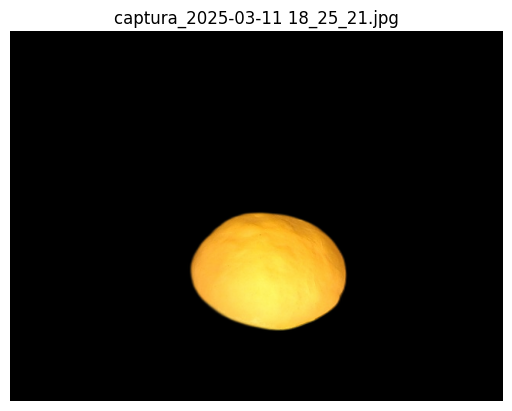

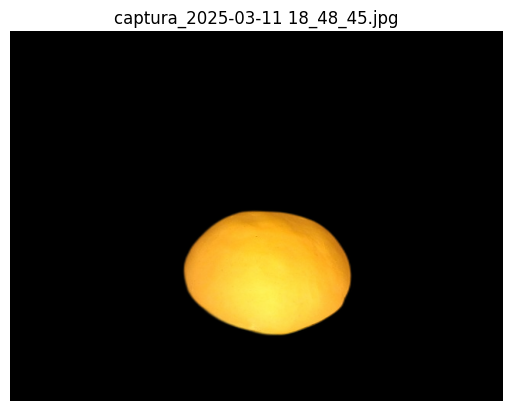

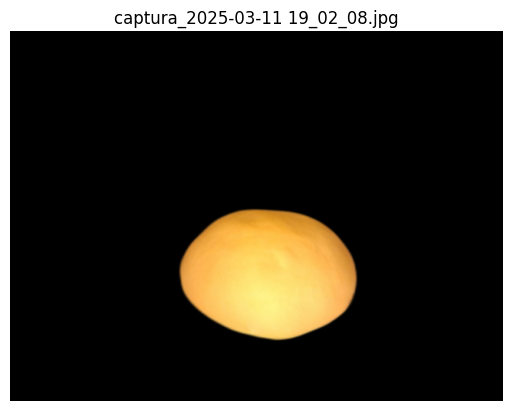

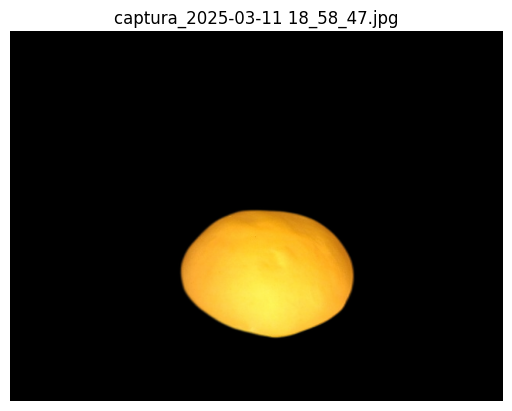

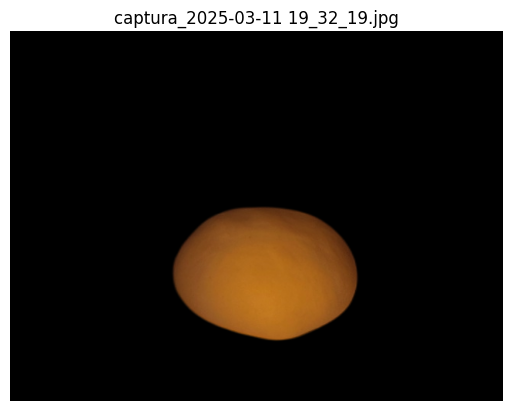

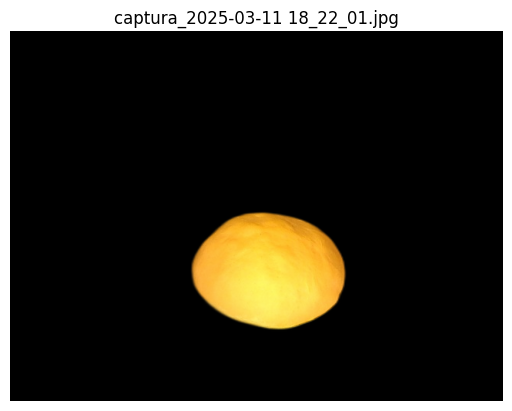

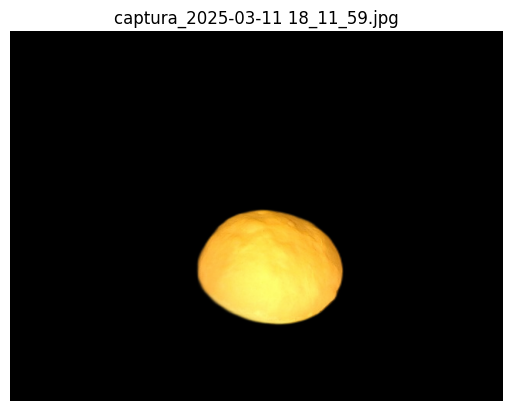

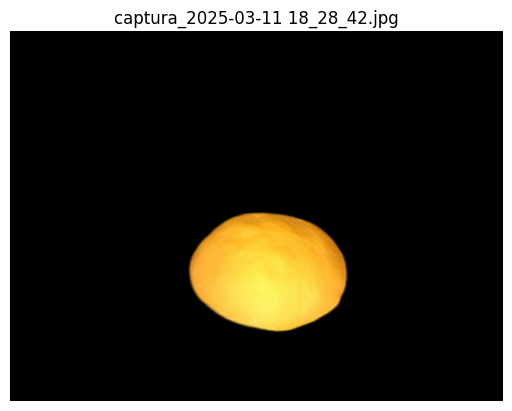

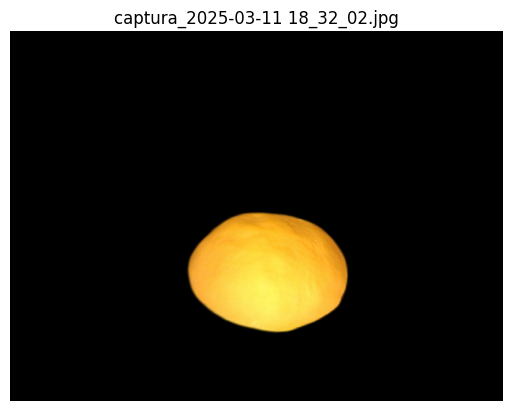

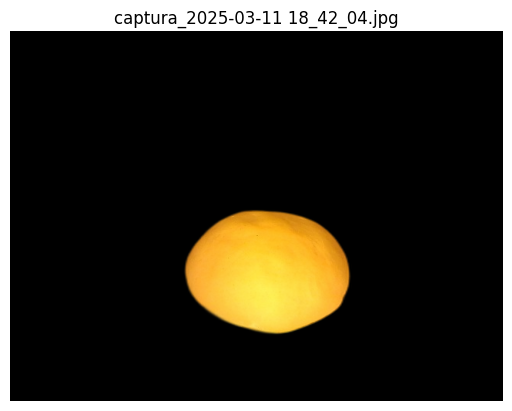

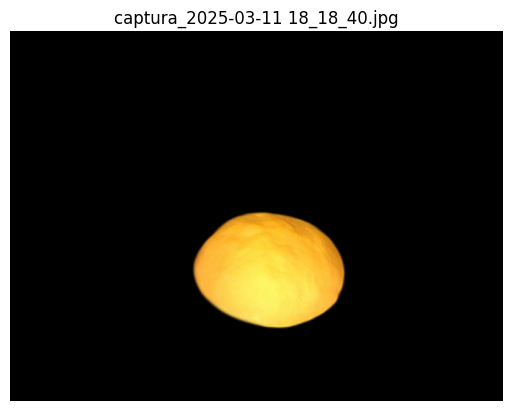

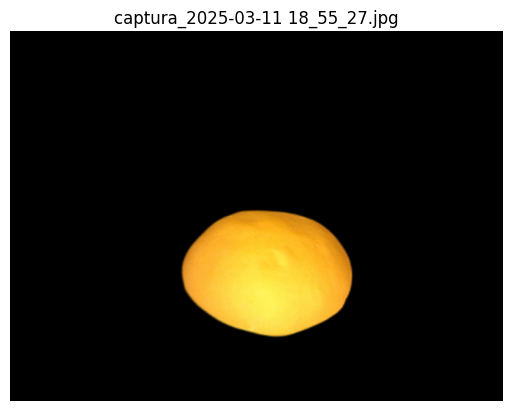

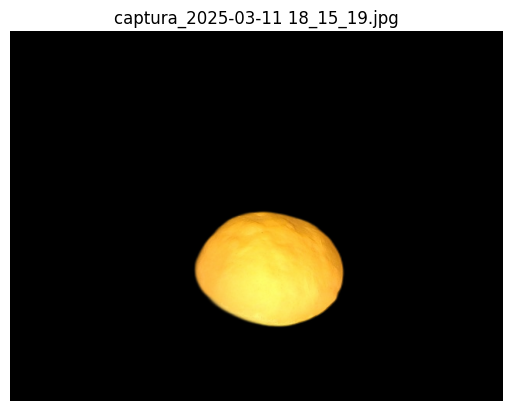

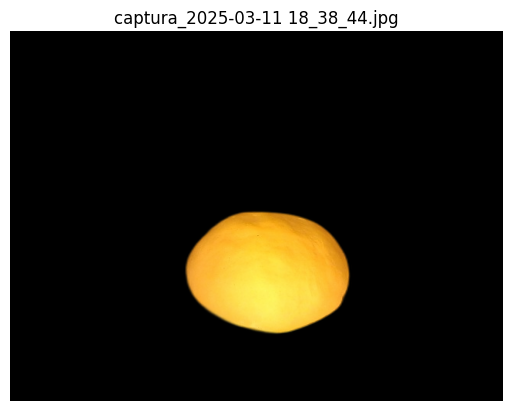

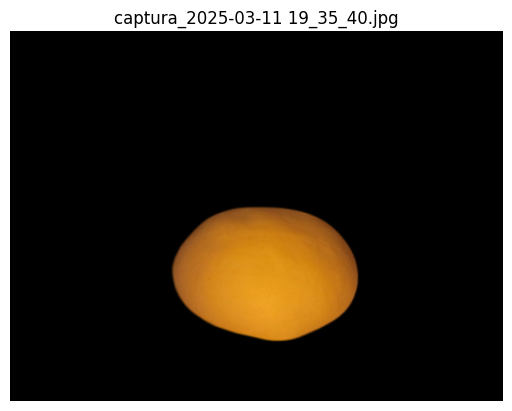

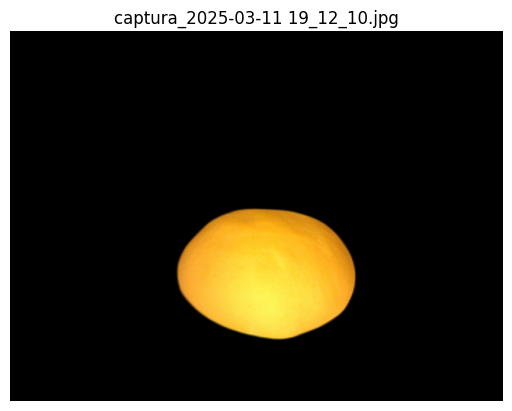

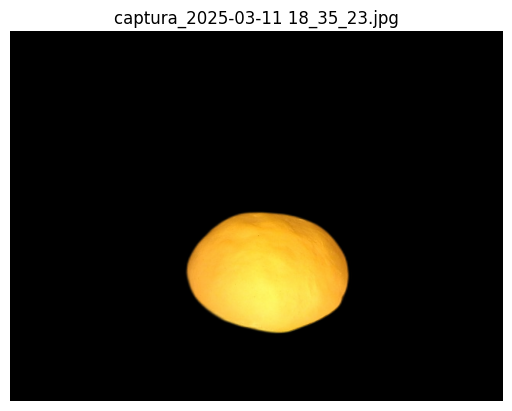

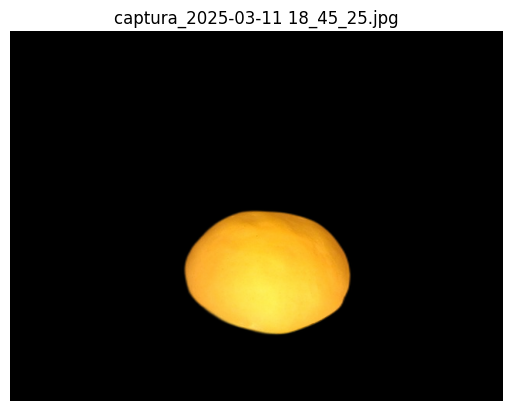

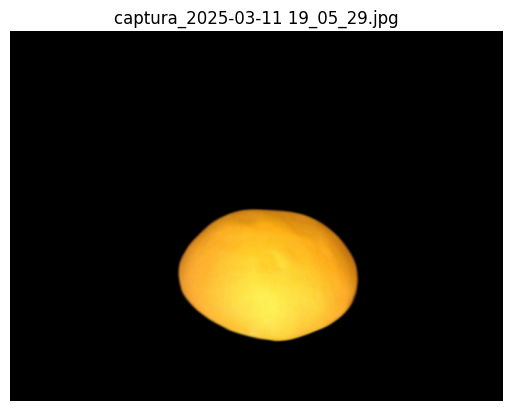

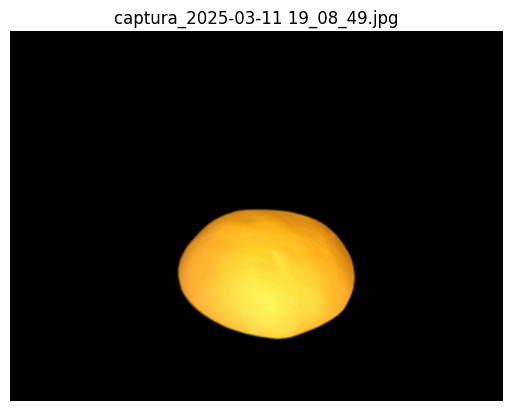

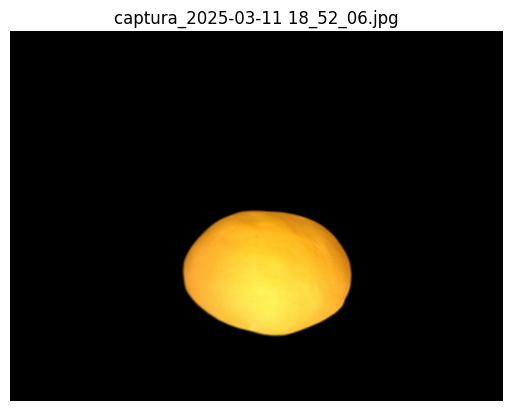

In [44]:
# Process each image
for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)

    # Remove background, unpack the tuple
    processed_image, original_image = remove_background(image_path)

    # Save the processed image
    output_path = os.path.join(output_folder, image_file)
    processed_image.save(output_path)

    # Example: Display the image
    plt.imshow(processed_image) # Display the processed image
    plt.title(image_file)
    plt.axis("off")
    plt.show()

# Por diferencia de volumen según un Elipsoide

Usando la librería rembg https://github.com/danielgatis/rembg he quitado el fondo de la imagen para tratar solo lo que nos interesa en este caso que es el pan

Podemos considerar las masas casi como elipsoides partidos por la mitad
Por lo que podemos calcular el contorno del pan mediante el volumen del elipsoide

In [45]:
def estimate_volume(image):
    image_cv = np.array(image)
    gray = cv2.cvtColor(image_cv, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return 0, None

    largest_contour = max(contours, key=cv2.contourArea)

    if len(largest_contour) < 5:
        return 0, None

    ellipse = cv2.fitEllipse(largest_contour)
    (x, y), (major_axis, minor_axis), angle = ellipse

    c = 0.6 * major_axis
    volume = ((4 / 3) * np.pi * (major_axis / 2) * (minor_axis / 2) * (c / 2)) * 0.5

    return volume, ellipse

In [46]:
def estimate_volume_cm3(image):
    volume, ellipse = estimate_volume(image)
    if ellipse is None:
        return 0, None

    (x, y), (major_axis, minor_axis), angle = ellipse
    major_axis_cm = major_axis / pixels_per_cm
    minor_axis_cm = minor_axis / pixels_per_cm
    c_cm = 0.6 * major_axis_cm
    volume_cm3 = ((4 / 3) * np.pi * (major_axis_cm / 2) * (minor_axis_cm / 2) * (c_cm / 2)) * 0.5

    return volume_cm3, ellipse

In [47]:
def plot_volume_evolution():
    plt.figure(figsize=(10, 5))
    plt.plot(time_labels, volumes, marker='o')
    plt.xlabel("Tiempo Transcurrido")
    plt.ylabel("Volumen (%)")
    plt.title("Evolución del Volumen del Pan")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('output_pan/evolucion_volumen.png')  # Guardar gráfico como imagen
    plt.show()

In [48]:
def create_video():
    output_folder = "output_pan"
    images = [img for img in os.listdir(output_folder) if img.endswith('.jpg') or img.endswith('.png')]
    images.sort()

    if not images:
        print("No se encontraron imágenes para crear el video.")
        return

    frame = cv2.imread(os.path.join(output_folder, images[0]))
    height, width, _ = frame.shape
    video_path = os.path.join(output_folder, "proceso_fermentacion.mp4")

    video = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'mp4v'), 0.5, (width, height))

    for image in images:
        frame = cv2.imread(os.path.join(output_folder, image))
        video.write(frame)

    video.release()
    print(f"Video guardado como: {video_path}")

In [49]:
def process_images(folder_path, output_folder):
    image_files = sorted([
        f for f in os.listdir(folder_path)
        if os.path.isfile(os.path.join(folder_path, f))
    ])
    os.makedirs(output_folder, exist_ok=True)

    global vol1, initial_time, volumes, time_labels
    vol1 = None
    initial_time = time.time()
    volumes = []
    time_labels = []

    font = cv2.FONT_HERSHEY_SIMPLEX
    color = (255, 255, 255)

    for i, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        image, original_image = remove_background(image_path)
        volume_cm3, ellipse = estimate_volume_cm3(image)

        file_time = image_file.split(' ')[1].replace('_', ':').split('.')[0]

        if i == 0:
            vol1 = volume_cm3
            first_ellipse = ellipse
            continue

        image_cv = np.array(original_image)  # Use the original image for drawing
        if ellipse:
            cv2.ellipse(image_cv, ellipse, (0, 255, 0), 2)
        if first_ellipse:
            cv2.ellipse(image_cv, first_ellipse, (0, 0, 255), 2)

        porcentaje_vol = ((volume_cm3 - vol1) / vol1) * 100
        time_label = file_time

        cv2.putText(image_cv, f"Foto {i + 1}: {time_label}", (10, 30), font, 1, color, 2)
        cv2.putText(image_cv, f"Volumen estimado: {porcentaje_vol:.2f}%", (10, 60), font, 1, color, 2)

        if porcentaje_vol >= 50:
            highest_threshold = max(umbral for umbral in thresholds if porcentaje_vol >= umbral)
            cv2.rectangle(image_cv, (20, 80), (260, 140), (255, 0, 0), 2)
            cv2.putText(image_cv, f"AVISO > {highest_threshold}%", (30, 120), font, 1, (255, 0, 0), 2)

        output_path = os.path.join(output_folder, image_file)
        Image.fromarray(image_cv).save(output_path)

        volumes.append(porcentaje_vol)
        time_labels.append(time_label)

    plot_volume_evolution()
    create_video()

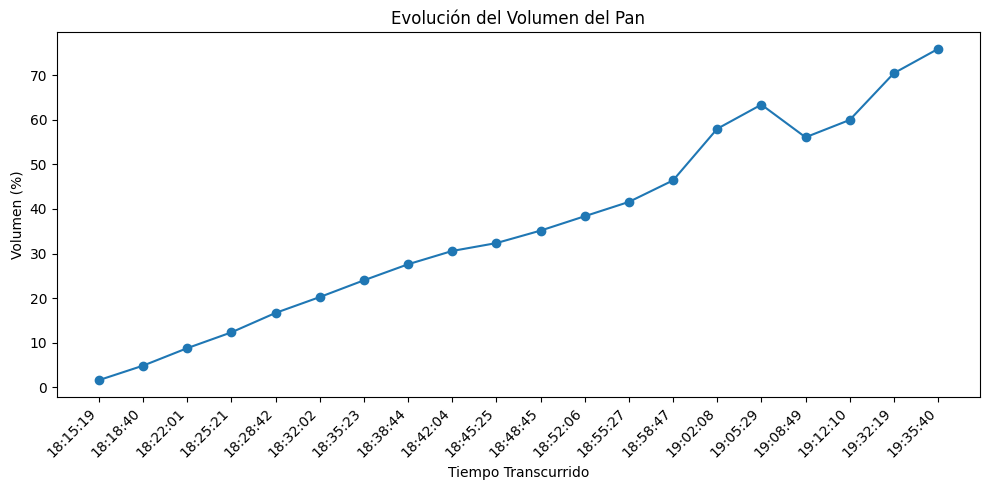

Video guardado como: output_pan/proceso_fermentacion.mp4


In [51]:
process_images('pan', 'output_pan')

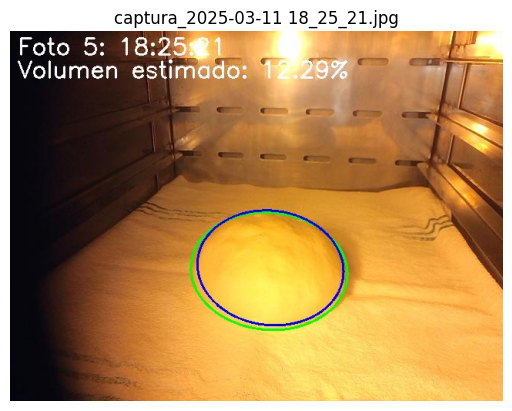

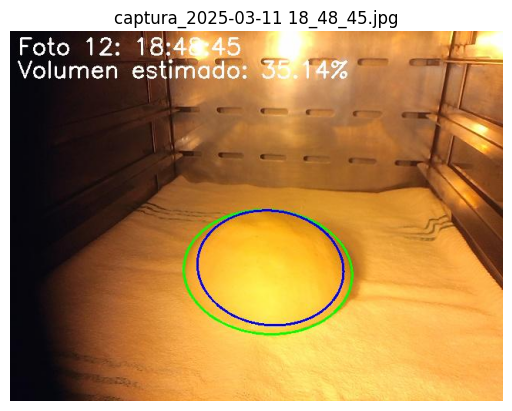

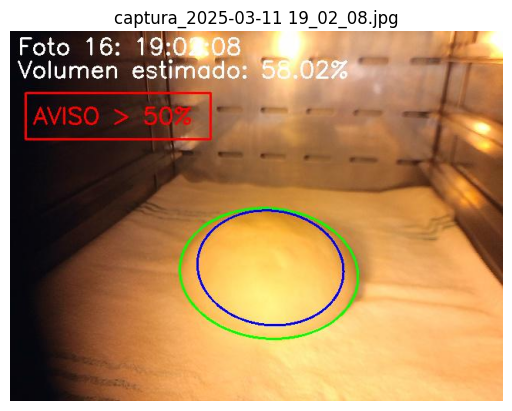

Error displaying proceso_fermentacion.mp4: cannot identify image file 'output_pan/proceso_fermentacion.mp4'


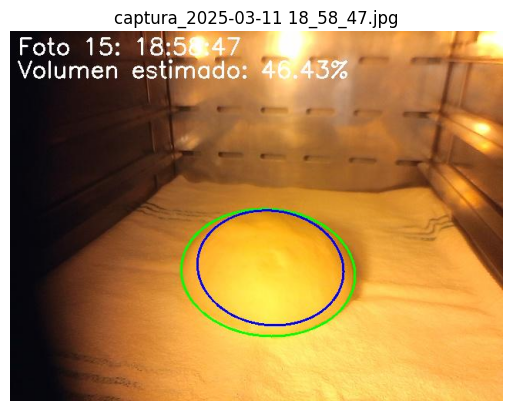

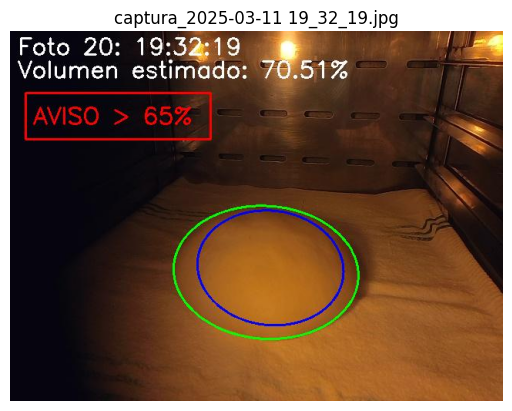

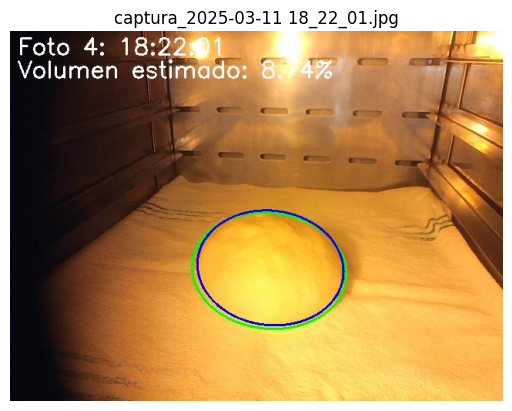

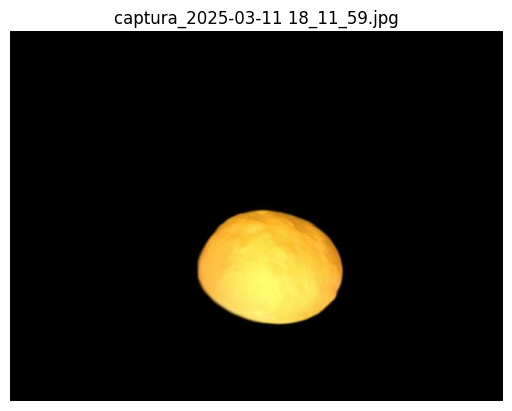

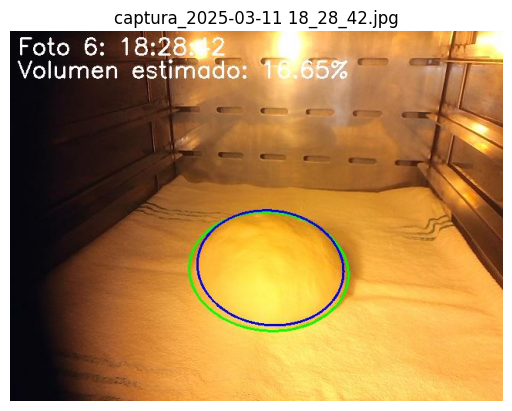

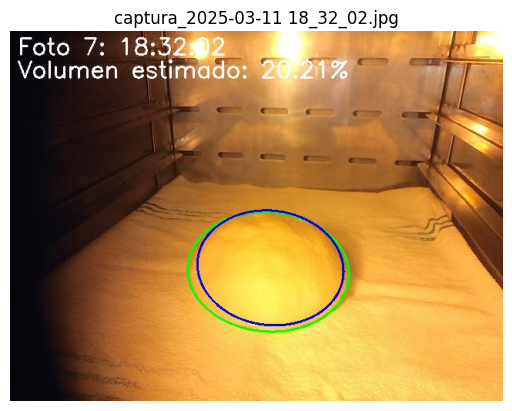

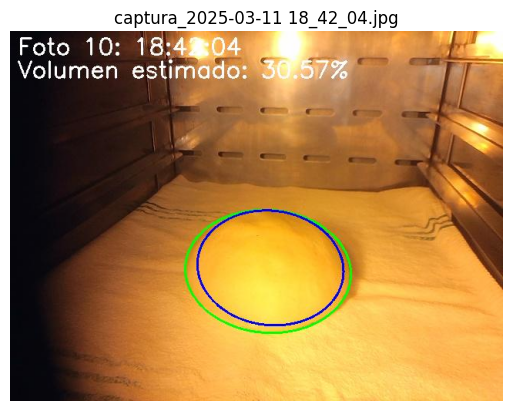

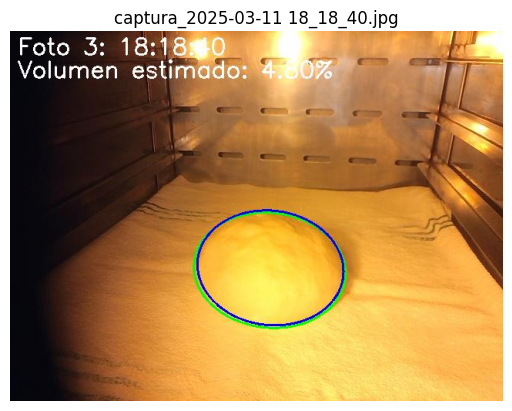

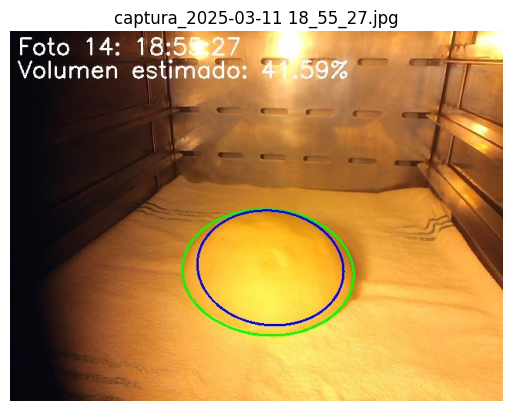

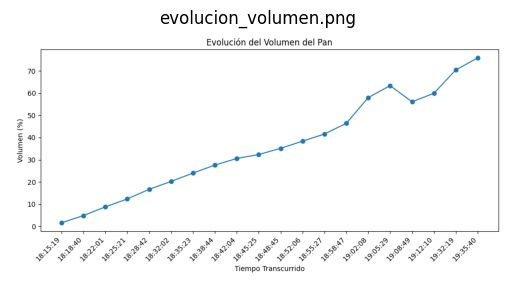

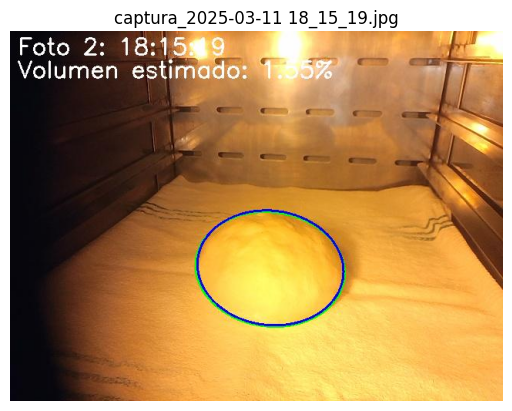

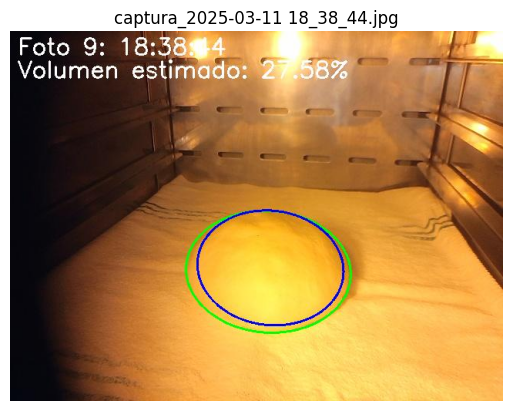

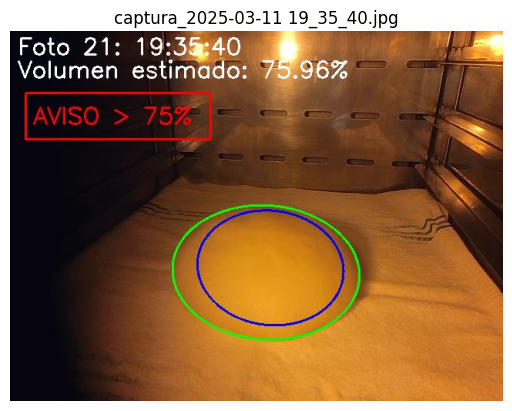

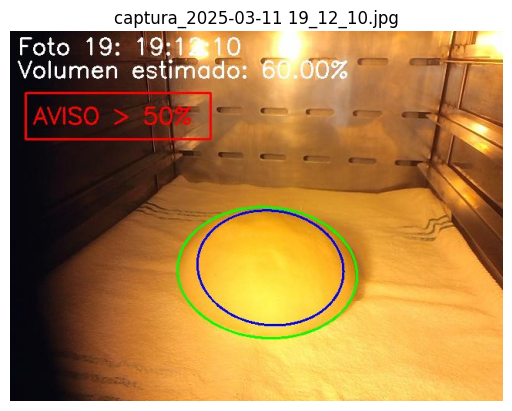

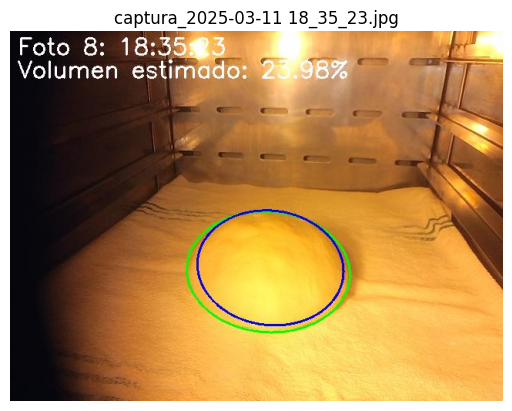

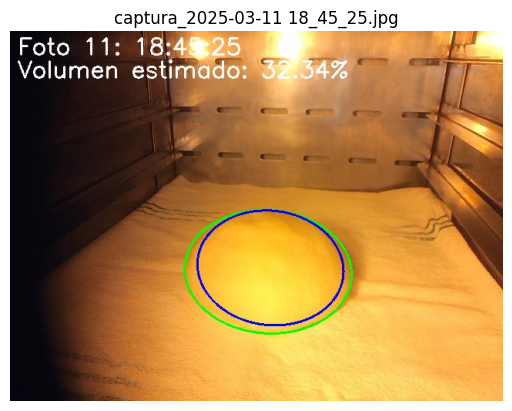

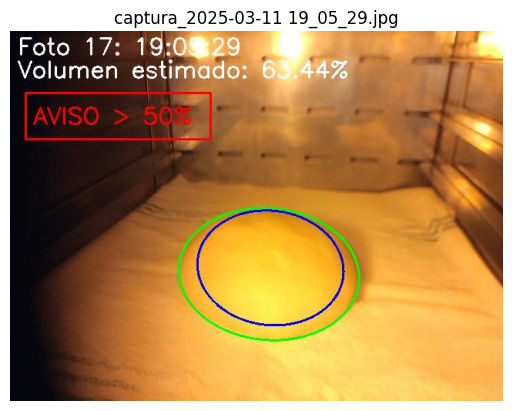

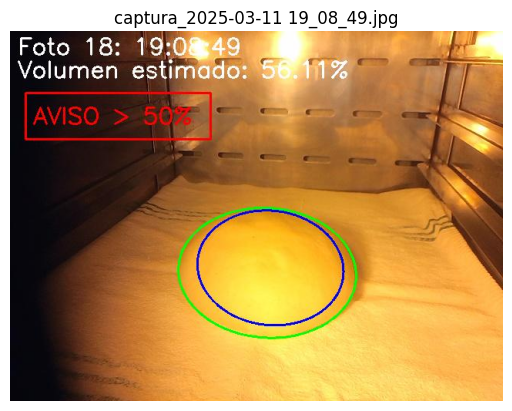

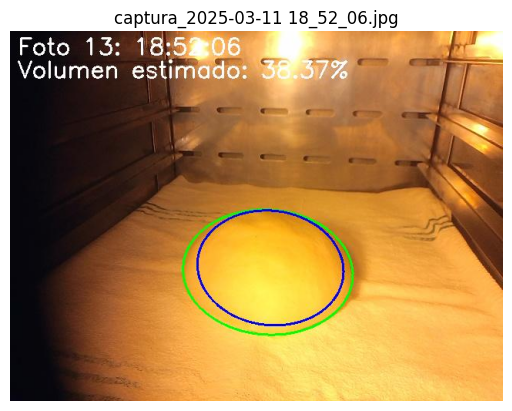

In [52]:
# Assuming 'output_pan' directory exists and contains images
output_folder = "output_pan"
image_files = [f for f in os.listdir(output_folder) if os.path.isfile(os.path.join(output_folder, f))]

for image_file in image_files:
    image_path = os.path.join(output_folder, image_file)
    try:
        # Display the image using matplotlib
        img = plt.imread(image_path)
        plt.imshow(img)
        plt.title(image_file)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error displaying {image_file}: {e}")


Reglas Generales para la Fermentación del Pan
Duplicación del Volumen (Aumento del 80%-100%)

En la mayoría de los panes, la masa debe crecer 1.8x a 2x su volumen inicial antes de hornear.
Esto asegura una estructura adecuada y buena esponjosidad después del horneado.
Ejemplo: Si la masa inicial tiene 300 cm³, debería alcanzar entre 540 cm³ y 600 cm³ antes de hornear.
Sobrefermentación (>2.5x su volumen inicial)

Si la masa crece más de 2.5 veces su volumen inicial, la estructura puede colapsar durante el horneado.
Se vuelve pegajosa, débil y puede hundirse en el centro.
Fermentación Insuficiente (<1.5x su volumen inicial)

Si la masa no alcanza al menos 1.5 veces su volumen inicial, el pan será denso y poco aireado.